## Config

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from common import *
import competitions.pascalvoc as comp;

/home/bfortuner/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
TRAIN_PATH = cfg.PATHS['datasets']['inputs']['trn_jpg'] 
TEST_PATH = cfg.PATHS['datasets']['inputs']['tst_jpg'] 
comp.make_metadata_file()
meta = utils.files.load_json(cfg.METADATA_PATH)

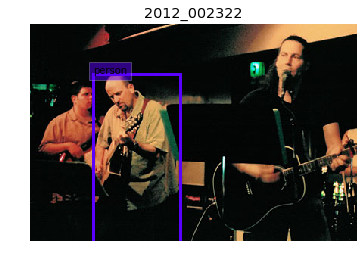

In [3]:
# View images
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH, strip_ext=True)
idx = random.randint(0, len(fpaths))
img = utils.imgs.load_img_as_arr(fpaths[idx])
bboxes =meta['imgs'][fnames[idx]]['bboxes']
title = meta['imgs'][fnames[idx]]['img_id']
utils.imgs.plot_img_w_bboxes(img, bboxes, title)

In [4]:
HARDWARE_CONFIG = {
    'hostname': socket.gethostname(),
    'random_seed': 3,
    'gpu_device':0
}
torch.cuda.set_device(HARDWARE_CONFIG['gpu_device'])
cudnn.benchmark = True

DATA_CONFIG = {
    'img_rescale': 300,
    'dset_fold': 'fold1',
    'n_classes': len(cfg.LABEL_NAMES) + 1, #extra background?
    'img_mean': (104, 117, 123)
}

TRAIN_CONFIG = {
    'initial_lr': 1e-3,
    'weight_decay': 5e-4,
    'momentum': 0.9,
    'n_epochs': 100,
    'n_cycles': 9,
    'early_stop_metric': metric.Loss().name,
    'max_patience': 20,
    'batch_size': 16,
    'threshold': 0.5,
    'save_weights_cadence': 1, #every epoch
    'lr_schedule': {}
}

vgg_weights_fpath = torch.load(os.path.join(
    cfg.PATHS['project'], 'pretrained', 
    'vgg16_reducedfc.pth'))

torch.set_default_tensor_type('torch.cuda.FloatTensor')
accum_batch_size = 32
iter_size = 2 #accum_batch_size / batch_size
max_iter = 120000
stepvalues = (80000, 100000, 120000)
OTHER_CONFIG = {}

TRANSFORMS = {
    c.TRAIN: torchsample.transforms.Compose([
        data_aug.SSDAugmentation(DATA_CONFIG['img_rescale'], 
                                 DATA_CONFIG['img_mean'])
    ]),
    c.VAL: torchsample.transforms.Compose([
        data_aug.SSDBaseAugmentation(DATA_CONFIG['img_rescale'], 
                                     DATA_CONFIG['img_mean'])
    ]),
    c.TEST: torchsample.transforms.Compose([
        data_aug.SSDBaseAugmentation(DATA_CONFIG['img_rescale'], 
                                     DATA_CONFIG['img_mean'])
    ]),
    c.TARGET: torchsample.transforms.Compose([
        data_aug.BBoxTransform(cfg.LABEL_TO_IDX)
    ]),
}

## Data

In [5]:
fpaths,fnames = utils.files.get_paths_to_files(TRAIN_PATH)
val_size = math.floor(len(fnames)*.15)
fold = data_folds.make_fold(DATA_CONFIG['dset_fold'], TRAIN_PATH, TEST_PATH,
                             cfg.PATHS['folds'], val_size, shuffle=True)
print("total", len(fpaths), "val",len(fold['val']), 'trn',len(fold['trn']))

total 17125 val 2568 trn 14557


In [6]:
SAMPLE = 1000000
fold = data_folds.load_data_fold(cfg.PATHS['folds'], DATA_CONFIG['dset_fold'])
trn_fpaths = data_folds.get_fpaths_from_fold(fold, c.TRAIN, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)[:SAMPLE]
val_fpaths = data_folds.get_fpaths_from_fold(fold, c.VAL, TRAIN_PATH,
                                             postfix=c.INPUT_POSTFIX)
tst_fpaths = data_folds.get_fpaths_from_fold(fold, c.TEST, TEST_PATH, postfix=c.JPG_EXT)

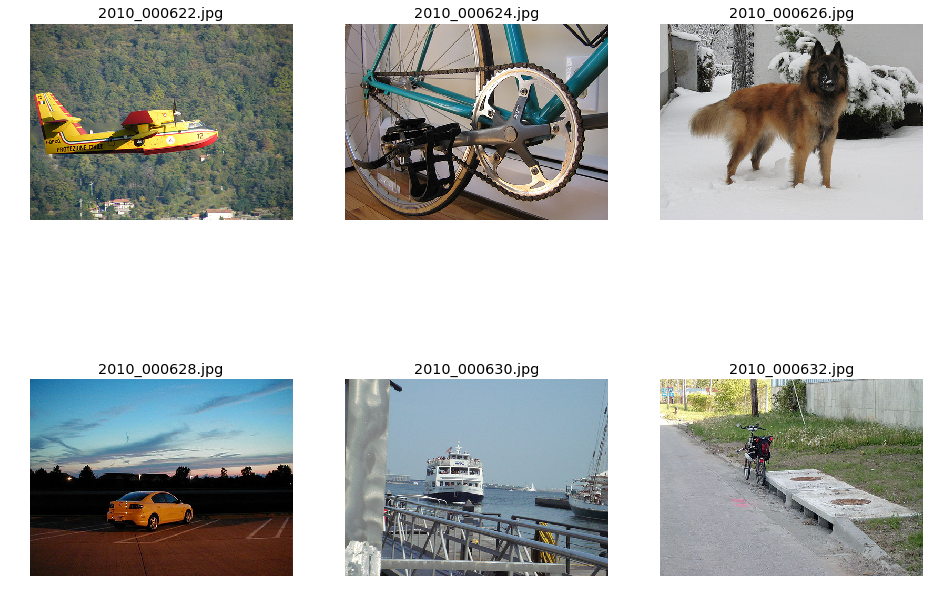

In [7]:
utils.imgs.plot_samples_from_dir(TRAIN_PATH, shuffle=True)

In [14]:
trn_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.TRAIN], meta, 
                                                 transform=TRANSFORMS[c.TRAIN], 
                                                 target_transform=TRANSFORMS[c.TARGET])
val_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.VAL], meta, 
                                                 transform=TRANSFORMS[c.VAL], 
                                                 target_transform=TRANSFORMS[c.TARGET])
tst_dataset = datasets.datasets.ObjDetectDataset(TRAIN_PATH, fold[c.VAL], meta, 
                                                 transform=TRANSFORMS[c.TEST], 
                                                 target_transform=TRANSFORMS[c.TARGET])
trn_loader = torch.utils.data.DataLoader(trn_dataset, TRAIN_CONFIG['batch_size'], 
                                         shuffle=True, num_workers=4, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
val_loader = torch.utils.data.DataLoader(val_dataset, 1, 
                                         shuffle=False, num_workers=2, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)
tst_loader = torch.utils.data.DataLoader(val_dataset, 1, 
                                         shuffle=False, num_workers=2, pin_memory=True,
                                         collate_fn=data_loaders.detection_collate)

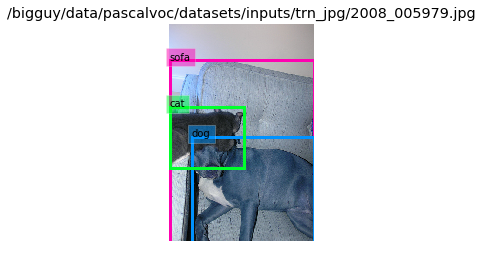

In [15]:
idx = random.randint(0, len(trn_dataset))
utils.imgs.plot_img_w_bboxes(trn_dataset.get_image(idx), 
                             trn_dataset.get_bboxes(idx), 
                             trn_dataset.get_fpath(idx))

In [16]:
from models.ssd import ssd
from models.ssd.multibox_loss import MultiBoxLoss
from models.ssd.detection import Detect

model = ssd.build_ssd('train', DATA_CONFIG['img_rescale'], 
                     DATA_CONFIG['n_classes'])
model.vgg.load_state_dict(vgg_weights_fpath)
model = model.cuda()

model.extras.apply(models.utils.xavier)
model.loc.apply(models.utils.xavier)
model.conf.apply(models.utils.xavier)

optimizer = optim.SGD(model.parameters(), lr=TRAIN_CONFIG['initial_lr'],
                      momentum=TRAIN_CONFIG['momentum'], 
                      weight_decay=TRAIN_CONFIG['weight_decay'])

criterion = MultiBoxLoss(
    DATA_CONFIG['n_classes'], 0.5, True, 
    0, True, 3, 0.5, False, True)

lr_adjuster = learning_rates.ScheduledLR(
    TRAIN_CONFIG['initial_lr'], 'mini_batch', 
    TRAIN_CONFIG['lr_schedule'])

detect = Detect(DATA_CONFIG['n_classes'], bkg_label=0,
                top_k=200, conf_thresh=0.01, nms_thresh=0.45)

In [ ]:
mod = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights(os.path.join('/bigguy/data/pascalvoc/pretrained', 'ssd300_mAP_77.43_v2.pth'))

In [17]:
im, targ = next(iter(val_loader))
im = Variable(im.cuda())
targ = [Variable(anno.cuda(), volatile=True) for anno in targ]

In [18]:
out = model(im)

In [19]:
out[0].size(), out[1].size(), out[2].size()

(torch.Size([1, 8732, 4]), torch.Size([1, 8732, 21]), torch.Size([8732, 4]))

In [20]:
loss_l, loss_c = criterion(out, targ)

/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/autograd/_functions/tensor.py:450: UserWarning: mask is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return tensor.masked_fill_(mask, value)


In [21]:
loss_l, loss_c

(Variable containing:
  1.4977
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
  24.6416
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [47]:
output = detect(
    out[0],
    nn.Softmax()(out[1].view(-1, DATA_CONFIG['n_classes'])),
    out[2].type(type(out[2].data))
)

In [33]:
img = utils.imgs.load_img_as_arr(os.path.join(TRAIN_PATH, val_loader.dataset.img_ids[0]+c.JPG_EXT))

torch.Size([1, 21, 200, 5])


/home/bfortuner/anaconda3/lib/python3.6/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)


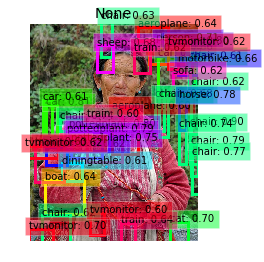

In [45]:
detections = output.data
print(detections.size())
scale = torch.Tensor([img.shape[1::-1], img.shape[1::-1]])
bboxes = []
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        bboxes.append({
            'label':cfg.IDX_TO_LABEL[i-1],
            'score': score,
            'xmin':pt[0],
            'ymin':pt[1],
            'xmax':pt[2]+1,
            'ymax':pt[3]+1
        })
        j+=1
utils.imgs.plot_img_w_bboxes(img, bboxes, title=None)

In [25]:
trainer = training.trainers.SSDTrainer(
    criterion, criterion, optimizer, lr_adjuster,
    data_aug.SSDBaseAugmentation(DATA_CONFIG['img_rescale'], DATA_CONFIG['img_mean']),
    cfg.IDX_TO_LABEL, )

In [27]:
trainer.test(model, val_loader, TRAIN_CONFIG['threshold'], metrics=[])

torch.Size([1, 3, 300, 300])


AttributeError: 'tuple' object has no attribute 'data'

## Train

In [ ]:
trainer.train(mode, trn_loader, TRAIN_CONFIG['threshold'], epoch=1, metrics=[])

In [ ]:
# Load existing weights (optional)
experiment_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd1e-05-bs32-fold5K-id767AD'
epoch = 30
exp_utils.load_weights_by_exp_and_epoch(model, experiment_name, epoch)

In [21]:
# Experiment config
NEW_EXP_NAME = 'SSD'
RESUME_EXP_NAME = None #'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
if not RESUME_EXP_NAME:
    EXP_NAME_ARGS = [utils.general.get_class_name(model), 
                    utils.general.get_class_name(optimizer), 
                    utils.general.get_class_name(lr_adjuster),
                    'img'+str(DATA_CONFIG['img_rescale']),
                    'lr'+str(TRAIN_CONFIG['initial_lr']),
                    'wd'+str(TRAIN_CONFIG['weight_decay']),
                    'bs'+str(TRAIN_CONFIG['batch_size']),
                    str(DATA_CONFIG['dset_fold'])]
    EXPERIMENT_NAME = exp_utils.generate_display_name(NEW_EXP_NAME, EXP_NAME_ARGS)
    METRICS = [metric.Loss()]#, metric.Accuracy(), metric.F2Score()]
    AUX_METRICS = [metric.AuxiliaryMetric('LearningRate', 'lr'), 
                   metric.AuxiliaryMetric('SystemMemory', 'mb')]
    VISUALIZERS = [Viz(EXPERIMENT_NAME)]

    EXP_CONFIG = {
        'name': EXPERIMENT_NAME,
        'parent_dir': cfg.PATHS['experiments'],
        'metrics': METRICS,
        'aux_metrics': AUX_METRICS,
        'visualizers': VISUALIZERS,
        'data': DATA_CONFIG,
        'training': TRAIN_CONFIG,
        'other': OTHER_CONFIG,
        'transforms': TRANSFORMS[c.TRAIN],
        'hardware': HARDWARE_CONFIG,
        'model': model,
        'optimizer': optimizer,
        'lr_adjuster': lr_adjuster,
        'criterion': criterion
    }

[autoreload of training.trainers failed: Traceback (most recent call last):
  File "/home/bfortuner/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
  File "/home/bfortuner/workplace/pytorch-kaggle-starter/training/trainers.py", line 330
    def train(self, model, loader, thresholds, epoch, metrics):
                                                              ^
IndentationError: unindent does not match any outer indentation level
]


NameError: name 'model' is not defined

In [ ]:
# Resume experiment
exp = Experiment(RESUME_EXP_NAME, cfg.PATHS['experiments'])
exp.resume(verbose=True)
trainer = trainers.Trainer(criterion, criterion, exp.optim, lr_adjuster)

In [ ]:
# Create new experiment
exp = Experiment(EXP_CONFIG['name'], cfg.PATHS['experiments'])
exp.init(EXP_CONFIG)
print(exp.name)

In [ ]:
exp.train(trainer, trn_loader, val_loader)

## Predict

In [ ]:
# Load model from exp epoch
exp.load_model_state(epoch=10)
model = exp.model

In [ ]:
# OR load custom model weights
exp_name = RESUME_EXP_NAME
w_path = os.path.join(cfg.PATHS['experiments'], exp_name, 'weights', 'weights-30.th')
models.utils.load_weights(model, w_path)

In [ ]:
%time val_probs = predictions.get_probabilities(model, val_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.VAL)
_ = predictions.save_or_append_pred_to_file(pred_fpath, val_probs)

In [ ]:
thresh = TRAIN_CONFIG['threshold']
acc = metric_utils.get_accuracy(val_probs > thresh, val_targs)
f2 = metric_utils.get_metric_in_blocks(val_probs > thresh, val_targs, 
                                       1000, metric_utils.get_f2_score)
loss = metric_utils.get_cross_entropy_loss(val_probs, val_targs)
print("Acc",acc,"F2",f2,"BCE",loss)
utils.imgs.plot_sample_preds(val_fpaths, val_probs > 0.5, val_targs, 
                             dogscats.LABEL_NAMES)

In [ ]:
%time tst_probs = predictions.get_probabilities(model, tst_loader)

In [ ]:
pred_fpath = predictions.get_prediction_fpath(basename='my_exp', dset=c.TEST)
_ = predictions.save_or_append_pred_to_file(pred_fpath, tst_probs)
tst_probs = predictions.load_pred(pred_fpath, numpy=True)
utils.imgs.plot_sample_preds(tst_fpaths, tst_probs > thresh, 
                             None, dogscats.LABEL_NAMES)

## Ensemble

In [ ]:
member_fpaths = predictions.list_local_preds(dset=c.TEST, fnames_only=False)
member_fpaths

In [ ]:
ens_fpath = ensembles.get_ensemble_fpath(basename='my_exp', dset=c.TEST)
_ = ensembles.ens_prediction_files(
    ens_fpath, member_fpaths, block_size=1000, method=c.MEAN)
ens_probs = predictions.load_pred(ens_fpath, numpy=True)

## Submit

In [ ]:
tst_probs = predictions.load_pred(pred_fpath, numpy=True)

In [ ]:
sub_fpath = submissions.get_sub_path_from_pred_path(pred_fpath)
fnames = utils.files.get_fnames_from_fpaths(tst_fpaths)
sub_ids = [f.split('.')[0] for f in fnames]
tst_probs = np.clip(tst_probs, .005, .995) #good for BCE problems
submissions.make_preds_submission(sub_fpath, sub_ids, 
                                  np.expand_dims(tst_probs[:,1],1), 
                                  dogscats.SUB_HEADER)

In [ ]:
# https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
# Public Leaderboard .0566, Top 8%
# kg submit -m 'my sub' -c dogs-vs-cats-redux-kernels-edition -v -u USERNAME -p PASSWORD planet_tst.csv
FileLink(sub_fpath)

## Evaluate

In [ ]:
# Review Experiment
exp_name = 'BaselineSimpleResnet-Adam-ScheduledLR-img256-lr0.001-wd0.0005-bs64-fold4K-id84E8D'
exp = Experiment(exp_name, cfg.PATHS['experiments'])
exp.review(verbose=False)
exp.history.plot()

In [ ]:
# Load Pred
fname = 'my_exp_val.bc'
thresh = TRAIN_CONFIG['threshold']
probs = predictions.load_pred(os.path.join(cfg.PATHS['predictions'], fname))
preds = predictions.get_predictions(probs, thresh)

In [ ]:
# View preds, probs, and targets
eval_df = evaluate.get_evaluate_df(preds, probs, val_targs, 
                                   val_fpaths, dogscats.LABEL_NAMES)
eval_df[:5]

In [ ]:
# View preds by label
LABEL = 'dog'
dog_preds_by_targ = evaluate.get_preds_by_target_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_pred = evaluate.get_preds_by_predicted_label(
    eval_df, LABEL, condensed=False)
dog_preds_by_targ[:5]

In [ ]:
# View preds by probability

# Confident dogs and right (TP)
confident_dogs_tp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.9, p_max=1.0)
# Confident dogs and wrong (FP)
confident_dogs_fp = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.9, p_max=1.0)
# Unconfident dogs and right (TN)
unconfident_dogs_tn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 0, p_min=0.0, p_max=0.1)
# Unconfident dogs and wrong (FN)
unconfident_dogs_fn = evaluate.get_preds_by_target_and_prob(
    eval_df, 'dog', 1, p_min=0.0, p_max=0.1)

# Annotation errors?
evaluate.plot_predictions(unconfident_dogs_fn, dogscats.LABEL_NAMES)
unconfident_dogs_fn

In [ ]:
# View predictions and probabilities
evaluate.plot_predictions(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Confusion Matrix
evaluate.plot_label_level_cms(eval_df, dogscats.LABEL_NAMES)

In [ ]:
# Plot ROC Curve
evaluate.plot_roc_curve(np.array(probs), val_targs)